In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

(
    yf.pdr_override()
)

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

In [3]:
# Loading Algorithm

from sklearn.linear_model import LinearRegression

# Regularization
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Decision Tree
from sklearn.tree import DecisionTreeRegressor

# ENSEMBLE

## Bagging
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Support Vector Machine
from sklearn.svm import SVR

# K-Nearest Neighbor
from sklearn.neighbors import KNeighborsRegressor

# Multi-layer Perceptron (Neural Networks)
from sklearn.neural_network import MLPRegressor

# for data split
from sklearn.model_selection import train_test_split

# for cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# for assessment
from sklearn.metrics import mean_squared_error

# for Feature Selection
from sklearn.feature_selection import chi2, f_regression
from sklearn.feature_selection import SelectKBest

# for time series models
import statsmodels.tsa.arima.model as stats
import statsmodels.api as sm

#for data preparation and visualization
from pandas.plotting import scatter_matrix

# for Pre-processing (Feature Engineering)
from sklearn.preprocessing import StandardScaler

# assumption checks for Time-Series
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
# Datetime
start = dt.datetime(2004, 11, 1)
end = dt.datetime(2023, 10, 31)

In [5]:
# SPY Data
SPY = pdr.get_data_yahoo("SPY",start,end)

[*********************100%%**********************]  1 of 1 completed


In [6]:
stock_data = SPY

In [7]:
return_period = 5

Y =\
    (np
     .log(stock_data["Adj Close"]
         )
     .diff(return_period)
     .shift(-return_period)
    )

X1 =\
    (
    pd
    .concat([np
             .log(stock_data["Adj Close"]
                 )
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]
            ],
           axis = 1
           )
    .dropna()
)

X1.columns = ["SPY_DT", "SPY_3DT", "SPY_6DT", "SPY_12DT"]

X2 = (pd.concat(
    [
        stock_data["Adj Close"].rolling(window=21).mean(),
        stock_data["Adj Close"].rolling(window=63).mean(),
        stock_data["Adj Close"].rolling(window=252).mean(),
        stock_data["Adj Close"].ewm(span=10).mean(),
        stock_data["Adj Close"].ewm(span=30).mean(),
        stock_data["Adj Close"].ewm(span=200).mean()
    ], axis=1)
      .dropna()
      )

X2.columns = ['SMA_21', 'SMA_63', 'SMA_252', 'EMA_10', 'EMA_30', 'EMA_200']

In [8]:
X=\
(
    pd
    .concat([X1, X2],
            axis = 1)
)

data =\
(
pd
.concat([Y, X],
        axis = 1)
.dropna()
.iloc[ : :return_period, :]
)

Y = data.loc[ : , Y.name]
X = data.loc[ : , X.columns]

In [9]:
#testing set
validation_size = 0.01

train_size =\
    int(len(X) 
        * 
        (1 - validation_size)
       )

X_train, X_test =\
    (X[0         :train_size], 
     X[train_size:len(X)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size], 
     Y[train_size:len(X)    ]
    )

In [10]:
num_folds = 10
seed = 231023
scoring = "neg_mean_squared_error"

models = []

models.append(("LR", LinearRegression()
             )
            )

models.append(("LASSO", Lasso()
             )
            )

models.append(("EN", ElasticNet()
             )
            )

models.append(("CART", DecisionTreeRegressor()
             )
            )

models.append(("KNN", KNeighborsRegressor()
             )
            )

models.append(("SVR", SVR()
             )
            )

# Bagging (Boostrap Aggregation)

models.append(("RFR", RandomForestRegressor()
              )
             )

models.append(("ETR", ExtraTreesRegressor()))

# Boosting

models.append(("GBR", GradientBoostingRegressor()))

models.append(("ABR", AdaBoostRegressor()))

# Alternatives
## light GMB
## CAT Boost

In [11]:
### Initialization of Lists:

names = []

kfold_results = []

train_results = []
test_results = []

for name, model in models:
    
    names.append(name)
    
    kfold =\
        (KFold(n_splits = num_folds,
               random_state = seed,
               shuffle = True)
        )
    
    cv_results =\
        (
         -1
         *
         cross_val_score(model, X_train, Y_train,
                         cv = kfold,
                         scoring = scoring)
        )
            
    kfold_results.append(cv_results)
  
    res = model.fit(X_train, Y_train) 

    train_result = mean_squared_error(res.predict(X_train), Y_train)
    
    train_results.append(train_result)
    
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    
    test_results.append(test_result)

    message = "%s: %f (%f) %f %f" % (name, cv_results.mean(), 
                                     cv_results.std(), 
                                     train_result, 
                                     test_result)
    print(message)

LR: 0.000661 (0.000189) 0.000634 0.000648
LASSO: 0.000650 (0.000186) 0.000649 0.000346
EN: 0.000650 (0.000186) 0.000649 0.000346
CART: 0.001350 (0.000389) 0.000000 0.000967
KNN: 0.000774 (0.000219) 0.000528 0.000334
SVR: 0.001984 (0.000171) 0.001987 0.001387
RFR: 0.000709 (0.000205) 0.000100 0.000362
ETR: 0.000714 (0.000198) 0.000000 0.000334
GBR: 0.000715 (0.000214) 0.000309 0.000421
ABR: 0.000934 (0.000178) 0.000727 0.000402


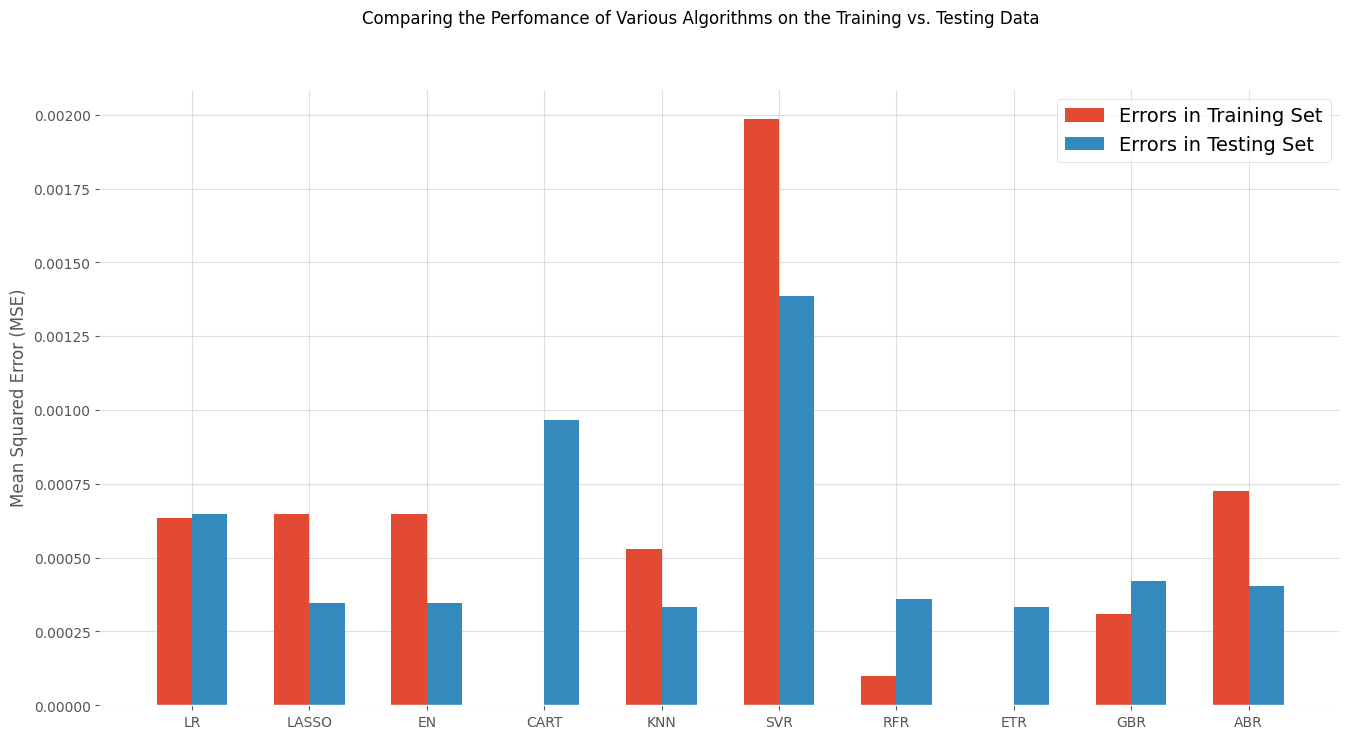

In [12]:
fig = plt.figure(figsize = [16, 8])

ind = np.arange(len(names)
               )

width = 0.30

fig.suptitle("Comparing the Perfomance of Various Algorithms on the Training vs. Testing Data")

ax = fig.add_subplot(111)

(plt
 .bar(ind - width/2,
      train_results,
      width = width,
      label = "Errors in Training Set")
)

(plt
 .bar(ind + width/2,
      test_results,
      width = width,
      label = "Errors in Testing Set")
)

plt.legend()

ax.set_xticks(ind)
ax.set_xticklabels(names)

plt.ylabel("Mean Squared Error (MSE)")

plt.show()

In [13]:
X

,SPY_DT,SPY_3DT,SPY_6DT,SPY_12DT,SMA_21,SMA_63,SMA_252,EMA_10,EMA_30,EMA_200
Date,,,,,,,,,,
2005-10-28,0.014038,0.001587,-0.030418,-0.027950,84.289201,85.697260,83.906753,84.137083,84.676709,84.690782
2005-11-04,0.019099,0.028576,0.005502,-0.009659,84.324865,85.596455,84.025088,85.246808,84.991808,84.746333
2005-11-11,0.013422,0.046559,0.005835,0.017015,85.077800,85.586891,84.131342,86.276425,85.502154,84.852136
2005-11-18,0.011009,0.043530,0.045116,0.032946,85.990872,85.712964,84.239995,87.216229,86.118195,84.998201
2005-11-28,0.008752,0.033183,0.061759,0.034324,87.241387,86.022421,84.384702,88.602669,87.043525,85.226371
...,...,...,...,...,...,...,...,...,...,...
2023-09-25,-0.026033,-0.039410,-0.027055,-0.009991,442.950524,444.110331,407.024926,438.010494,441.547293,422.428114
2023-10-02,-0.011448,-0.044766,-0.017758,-0.022443,438.657176,443.240885,408.352806,431.163887,437.451576,422.653847
2023-10-09,0.011587,-0.025894,-0.014089,-0.035028,434.058273,442.238743,409.579923,428.888253,434.450496,422.844773


In [14]:
Y

Date
2005-10-28    0.019099
2005-11-04    0.013422
2005-11-11    0.011009
2005-11-18    0.008752
2005-11-28    0.002769
                ...   
2023-09-25   -0.011448
2023-10-02    0.011587
2023-10-09    0.008637
2023-10-16   -0.036385
2023-10-23   -0.011650
Name: Adj Close, Length: 906, dtype: float64

In [15]:
def backtest(model,model_name):
    M= model
    M.fit(X,Y)
    Predicts=pd.Series(M.predict(X))
    Predicts.index = Y.index
    Predicts.name='predicts'

    data=pd.concat([SPY['Adj Close'],Predicts],axis=1,join='inner')
    data['return']=np.log(data['Adj Close']/data['Adj Close'].shift(1))
    data['cum_returns']=data['return'].cumsum().apply(np.exp)
    data['strategy']=data['return']*np.sign(data['predicts']).shift(1)
    data['cum_strategy']=data['strategy'].cumsum().apply(np.exp)
    data['cum_max']= data['cum_strategy'].cummax()
    neg = data['strategy'][data['strategy']<0].count()
    accuracy = 1-(neg/len(Y))
#
    sharpe_ratio=(data['strategy'].mean()/data['strategy'].std())*np.sqrt(252)
    D = (data.index[-1]-data.index[0]).days
    CAGR = (((data['cum_strategy'][-1]) / (data["cum_strategy"][1])) ** (365.0/D)) - 1
    drawdown_daily = data['cum_strategy']/data['cum_max']-1
    max_drawdown = -drawdown_daily.min()
    total_asset=100000.0 * data['cum_strategy'][-1]
    
    table=pd.DataFrame({'Sharpe Ratio': sharpe_ratio, 
                        'CAGR': CAGR,
                        'Max Drawdown': max_drawdown,
                        'Total Asset': total_asset,
                        'Strategy Return': data['cum_strategy'][-1]
    },columns=['Sharpe Ratio','CAGR','Max Drawdown','Total Asset','Strategy Return'],index=[model_name])
     
    data[['cum_strategy','cum_returns']].plot(figsize=(10,6))
    print(accuracy)
    
    return data,table

0.58719646799117


,Adj Close,predicts,return,cum_returns,strategy,cum_strategy,cum_max
Date,,,,,,,
2005-10-28,84.639412,0.000375,NaN,NaN,NaN,NaN,NaN
2005-11-04,86.271469,0.001301,0.019099,1.019282,0.019099,1.019282,1.019282
2005-11-11,87.437195,-0.000395,0.013422,1.033055,0.013422,1.033055,1.033055
2005-11-18,88.405098,0.001835,0.011009,1.044491,-0.011009,1.021745,1.033055
2005-11-28,89.182259,0.002929,0.008752,1.053673,0.008752,1.030727,1.033055
...,...,...,...,...,...,...,...
2023-09-25,432.230011,0.007211,-0.026033,5.106723,-0.026033,13.275021,13.808629
2023-10-02,427.309998,0.007263,-0.011448,5.048594,-0.011448,13.123913,13.808629
2023-10-09,432.290009,0.006927,0.011587,5.107432,0.011587,13.276864,13.808629


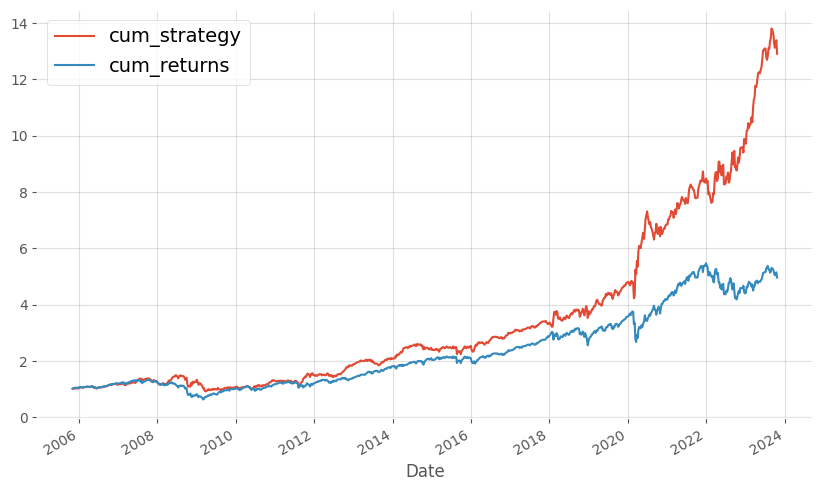

In [16]:
LR,LRT = backtest(LinearRegression(),"LR")
LR

0.5960264900662251


,Adj Close,predicts,return,cum_returns,strategy,cum_strategy,cum_max
Date,,,,,,,
2005-10-28,84.639412,0.001756,NaN,NaN,NaN,NaN,NaN
2005-11-04,86.271469,0.001756,0.019099,1.019282,0.019099,1.019282,1.019282
2005-11-11,87.437195,0.001756,0.013422,1.033055,0.013422,1.033055,1.033055
2005-11-18,88.405098,0.001756,0.011009,1.044491,0.011009,1.044491,1.044491
2005-11-28,89.182259,0.001756,0.008752,1.053673,0.008752,1.053673,1.053673
...,...,...,...,...,...,...,...
2023-09-25,432.230011,0.001756,-0.026033,5.106723,-0.026033,5.106723,5.475167
2023-10-02,427.309998,0.001756,-0.011448,5.048594,-0.011448,5.048594,5.475167
2023-10-09,432.290009,0.001756,0.011587,5.107432,0.011587,5.107432,5.475167


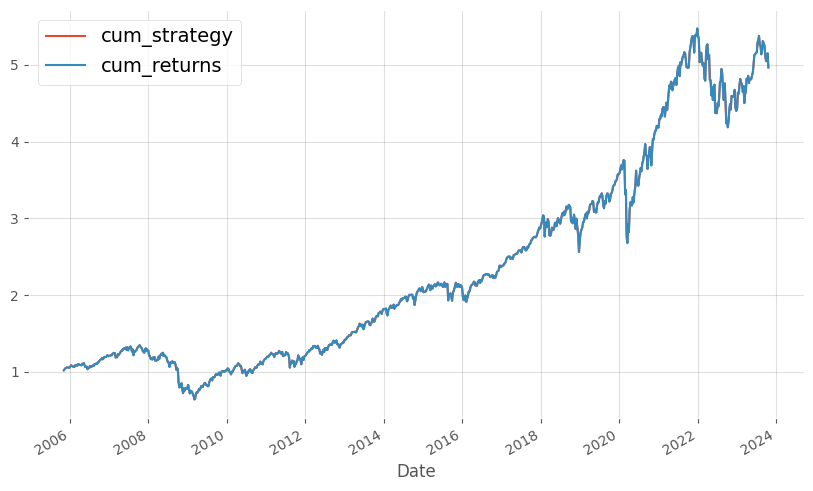

In [17]:
LASSO,LASSOT = backtest(Lasso(),"LASSO")
LASSO

0.5960264900662251


,Adj Close,predicts,return,cum_returns,strategy,cum_strategy,cum_max
Date,,,,,,,
2005-10-28,84.639412,0.001756,NaN,NaN,NaN,NaN,NaN
2005-11-04,86.271469,0.001756,0.019099,1.019282,0.019099,1.019282,1.019282
2005-11-11,87.437195,0.001756,0.013422,1.033055,0.013422,1.033055,1.033055
2005-11-18,88.405098,0.001756,0.011009,1.044491,0.011009,1.044491,1.044491
2005-11-28,89.182259,0.001756,0.008752,1.053673,0.008752,1.053673,1.053673
...,...,...,...,...,...,...,...
2023-09-25,432.230011,0.001756,-0.026033,5.106723,-0.026033,5.106723,5.475167
2023-10-02,427.309998,0.001756,-0.011448,5.048594,-0.011448,5.048594,5.475167
2023-10-09,432.290009,0.001756,0.011587,5.107432,0.011587,5.107432,5.475167


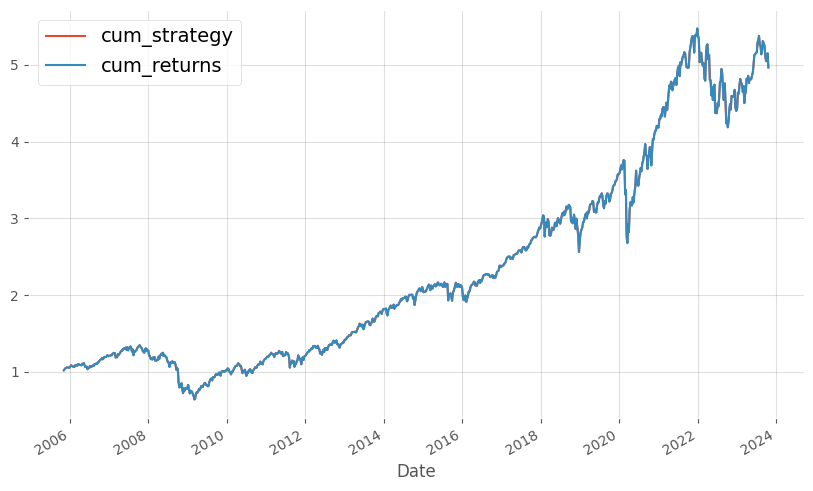

In [18]:
EN,ENT = backtest(ElasticNet(),"EN")
EN

1.0


,Adj Close,predicts,return,cum_returns,strategy,cum_strategy,cum_max
Date,,,,,,,
2005-10-28,84.639412,0.019099,NaN,NaN,NaN,NaN,NaN
2005-11-04,86.271469,0.013422,0.019099,1.019282,0.019099,1.019282e+00,1.019282e+00
2005-11-11,87.437195,0.011009,0.013422,1.033055,0.013422,1.033055e+00,1.033055e+00
2005-11-18,88.405098,0.008752,0.011009,1.044491,0.011009,1.044491e+00,1.044491e+00
2005-11-28,89.182259,0.002769,0.008752,1.053673,0.008752,1.053673e+00,1.053673e+00
...,...,...,...,...,...,...,...
2023-09-25,432.230011,-0.011448,-0.026033,5.106723,0.026033,6.876554e+06,6.876554e+06
2023-10-02,427.309998,0.011587,-0.011448,5.048594,0.011448,6.955730e+06,6.955730e+06
2023-10-09,432.290009,0.008637,0.011587,5.107432,0.011587,7.036795e+06,7.036795e+06


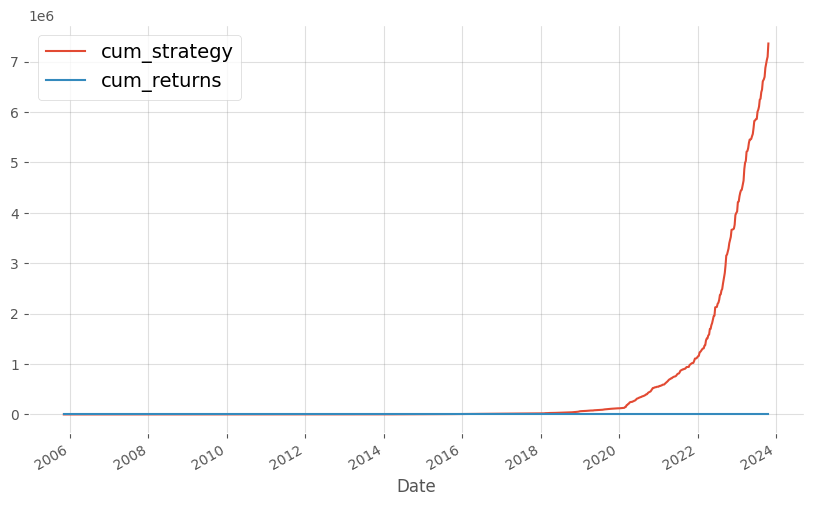

In [19]:
CART,CARTT = backtest(DecisionTreeRegressor(),"CART")
CART

0.6600441501103753


,Adj Close,predicts,return,cum_returns,strategy,cum_strategy,cum_max
Date,,,,,,,
2005-10-28,84.639412,0.016970,NaN,NaN,NaN,NaN,NaN
2005-11-04,86.271469,0.012261,0.019099,1.019282,0.019099,1.019282,1.019282
2005-11-11,87.437195,0.003050,0.013422,1.033055,0.013422,1.033055,1.033055
2005-11-18,88.405098,-0.004784,0.011009,1.044491,0.011009,1.044491,1.044491
2005-11-28,89.182259,0.001070,0.008752,1.053673,-0.008752,1.035389,1.044491
...,...,...,...,...,...,...,...
2023-09-25,432.230011,-0.005135,-0.026033,5.106723,0.026033,3806.907558,3806.907558
2023-10-02,427.309998,-0.007852,-0.011448,5.048594,0.011448,3850.739990,3850.739990
2023-10-09,432.290009,-0.004460,0.011587,5.107432,-0.011587,3806.379197,3850.739990


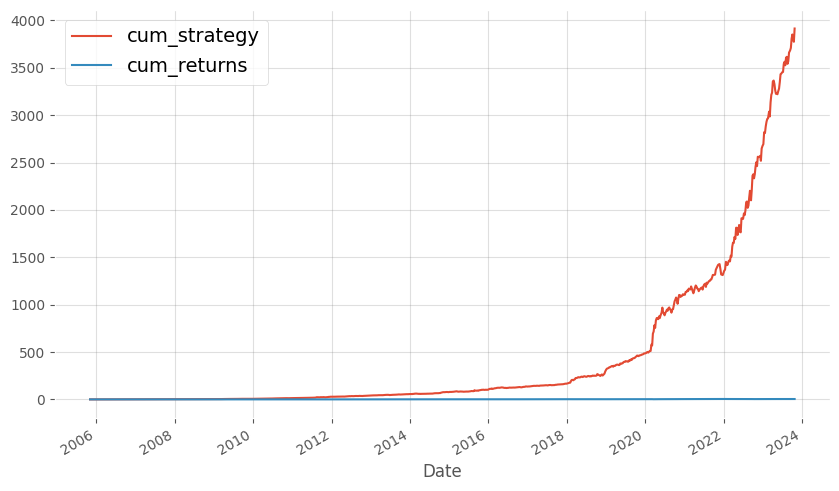

In [20]:
KNN,KNNT = backtest(KNeighborsRegressor(),"KNN")
KNN

0.4050772626931567


,Adj Close,predicts,return,cum_returns,strategy,cum_strategy,cum_max
Date,,,,,,,
2005-10-28,84.639412,-0.022707,NaN,NaN,NaN,NaN,NaN
2005-11-04,86.271469,-0.022981,0.019099,1.019282,-0.019099,0.981082,0.981082
2005-11-11,87.437195,-0.023424,0.013422,1.033055,-0.013422,0.968002,0.981082
2005-11-18,88.405098,-0.023907,0.011009,1.044491,-0.011009,0.957404,0.981082
2005-11-28,89.182259,-0.024607,0.008752,1.053673,-0.008752,0.949061,0.981082
...,...,...,...,...,...,...,...
2023-09-25,432.230011,-0.037040,-0.026033,5.106723,0.026033,0.195820,1.563980
2023-10-02,427.309998,-0.036836,-0.011448,5.048594,0.011448,0.198075,1.563980
2023-10-09,432.290009,-0.036573,0.011587,5.107432,-0.011587,0.195793,1.563980


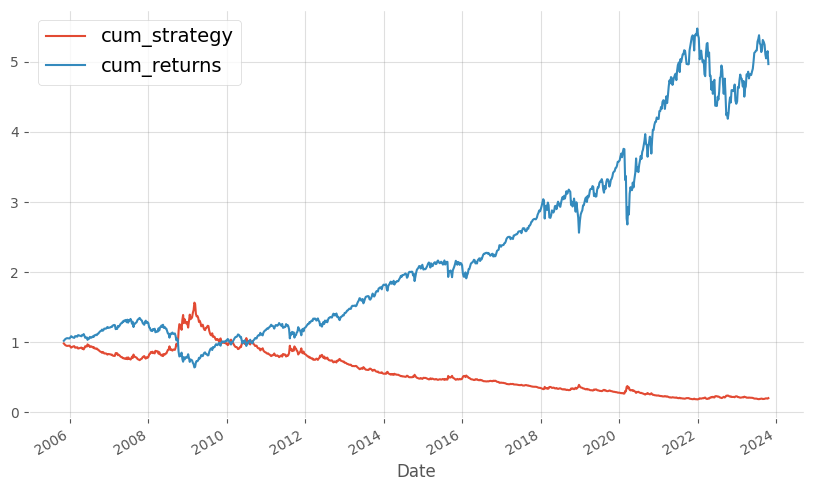

In [21]:
SVR,SVRT = backtest(SVR(),"SVR")
SVR

0.923841059602649


,Adj Close,predicts,return,cum_returns,strategy,cum_strategy,cum_max
Date,,,,,,,
2005-10-28,84.639412,0.015112,NaN,NaN,NaN,NaN,NaN
2005-11-04,86.271469,0.007999,0.019099,1.019282,0.019099,1.019282e+00,1.019282e+00
2005-11-11,87.437195,0.010413,0.013422,1.033055,0.013422,1.033055e+00,1.033055e+00
2005-11-18,88.405098,0.008067,0.011009,1.044491,0.011009,1.044491e+00,1.044491e+00
2005-11-28,89.182259,0.002781,0.008752,1.053673,0.008752,1.053673e+00,1.053673e+00
...,...,...,...,...,...,...,...
2023-09-25,432.230011,-0.001637,-0.026033,5.106723,0.026033,4.458430e+06,4.458430e+06
2023-10-02,427.309998,0.006588,-0.011448,5.048594,0.011448,4.509764e+06,4.509764e+06
2023-10-09,432.290009,0.003097,0.011587,5.107432,0.011587,4.562323e+06,4.562323e+06


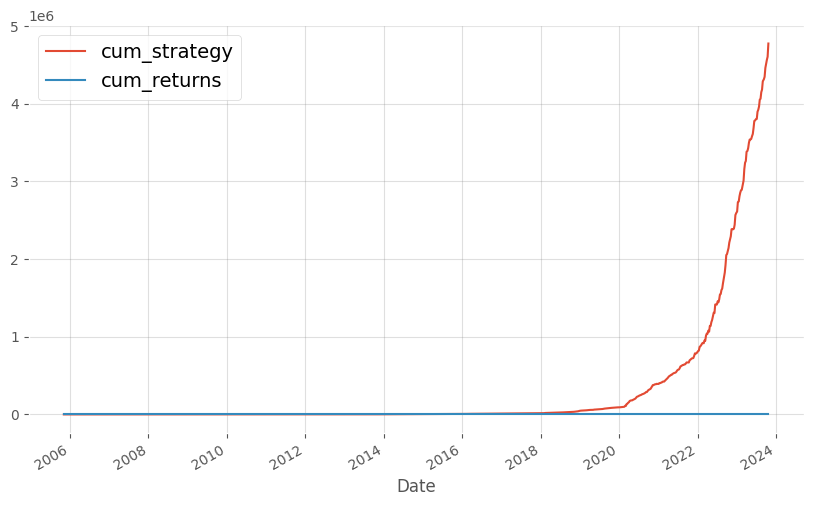

In [22]:
RFR,RFRT = backtest(RandomForestRegressor(),"RFR")
RFR

1.0


,Adj Close,predicts,return,cum_returns,strategy,cum_strategy,cum_max
Date,,,,,,,
2005-10-28,84.639412,0.019099,NaN,NaN,NaN,NaN,NaN
2005-11-04,86.271469,0.013422,0.019099,1.019282,0.019099,1.019282e+00,1.019282e+00
2005-11-11,87.437195,0.011009,0.013422,1.033055,0.013422,1.033055e+00,1.033055e+00
2005-11-18,88.405098,0.008752,0.011009,1.044491,0.011009,1.044491e+00,1.044491e+00
2005-11-28,89.182259,0.002769,0.008752,1.053673,0.008752,1.053673e+00,1.053673e+00
...,...,...,...,...,...,...,...
2023-09-25,432.230011,-0.011448,-0.026033,5.106723,0.026033,6.876554e+06,6.876554e+06
2023-10-02,427.309998,0.011587,-0.011448,5.048594,0.011448,6.955730e+06,6.955730e+06
2023-10-09,432.290009,0.008637,0.011587,5.107432,0.011587,7.036795e+06,7.036795e+06


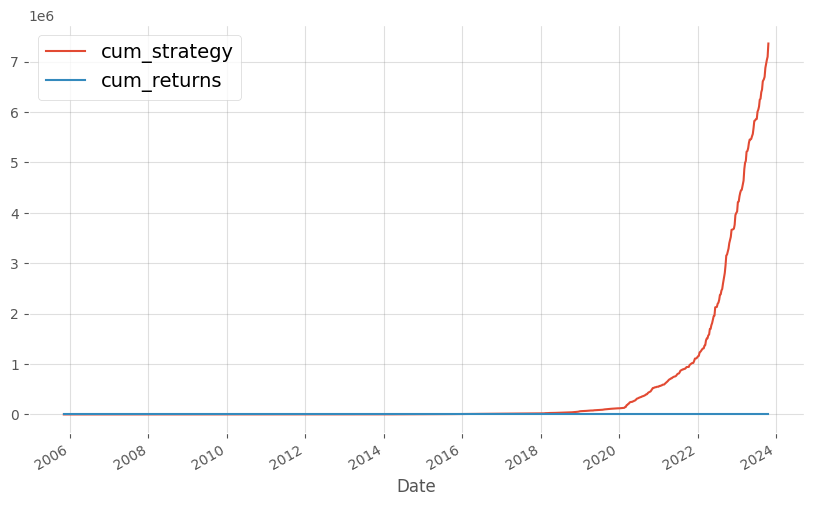

In [23]:
ETR,ETRT = backtest(ExtraTreesRegressor(),"ETR")
ETR

0.7163355408388521


,Adj Close,predicts,return,cum_returns,strategy,cum_strategy,cum_max
Date,,,,,,,
2005-10-28,84.639412,0.008549,NaN,NaN,NaN,NaN,NaN
2005-11-04,86.271469,0.005851,0.019099,1.019282,0.019099,1.019282,1.019282
2005-11-11,87.437195,0.005289,0.013422,1.033055,0.013422,1.033055,1.033055
2005-11-18,88.405098,-0.001360,0.011009,1.044491,0.011009,1.044491,1.044491
2005-11-28,89.182259,0.000283,0.008752,1.053673,-0.008752,1.035389,1.044491
...,...,...,...,...,...,...,...
2023-09-25,432.230011,0.000391,-0.026033,5.106723,0.026033,35183.102195,35183.102195
2023-10-02,427.309998,-0.002171,-0.011448,5.048594,-0.011448,34782.617890,35183.102195
2023-10-09,432.290009,-0.000782,0.011587,5.107432,-0.011587,34381.919711,35183.102195


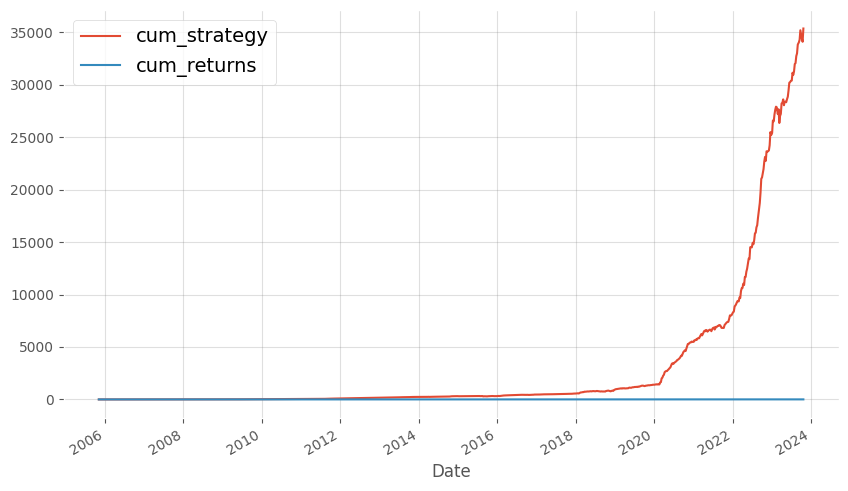

In [24]:
GBR,GBRT = backtest(GradientBoostingRegressor(),"GBR")
GBR

0.45253863134657835


,Adj Close,predicts,return,cum_returns,strategy,cum_strategy,cum_max
Date,,,,,,,
2005-10-28,84.639412,0.000170,NaN,NaN,NaN,NaN,NaN
2005-11-04,86.271469,-0.001891,0.019099,1.019282,0.019099,1.019282,1.019282
2005-11-11,87.437195,0.000170,0.013422,1.033055,-0.013422,1.005693,1.019282
2005-11-18,88.405098,0.000170,0.011009,1.044491,0.011009,1.016826,1.019282
2005-11-28,89.182259,0.000170,0.008752,1.053673,0.008752,1.025765,1.025765
...,...,...,...,...,...,...,...
2023-09-25,432.230011,-0.008941,-0.026033,5.106723,0.026033,5.634627,6.230315
2023-10-02,427.309998,-0.018746,-0.011448,5.048594,0.011448,5.699504,6.230315
2023-10-09,432.290009,-0.016485,0.011587,5.107432,-0.011587,5.633845,6.230315


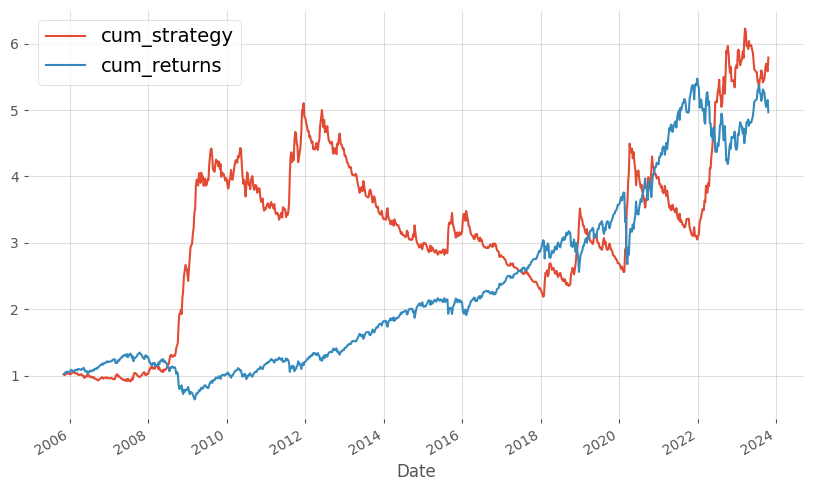

In [25]:
ABR,ABRT = backtest(AdaBoostRegressor(),"ABR")
ABR

In [26]:
Values = pd.concat([LRT,LASSOT,ENT,CARTT,KNNT,SVRT,RFRT,ETRT,GBRT,ABRT])

In [27]:
Values

,Sharpe Ratio,CAGR,Max Drawdown,Total Asset,Strategy Return
LR,1.770947,0.151525,0.384941,1.291353e+06,1.291353e+01
LASSO,1.105454,0.091994,0.525012,4.967662e+05,4.967662e+00
EN,1.105454,0.091994,0.525012,4.967662e+05,4.967662e+00
CART,14.943201,1.404879,-0.000000,7.360845e+11,7.360845e+06
KNN,6.096726,0.581817,0.150754,3.913475e+08,3.913475e+03
SVR,-1.105454,-0.084244,0.883219,2.013019e+04,2.013019e-01
RFR,14.197251,1.347668,0.032332,4.772422e+11,4.772422e+06
ETR,14.943201,1.404879,-0.000000,7.360845e+11,7.360845e+06
GBR,8.087159,0.787580,0.108613,3.534929e+09,3.534929e+04
ABR,1.211967,0.101353,0.571550,5.792358e+05,5.792358e+00


In [28]:
return_period = 5

Y =\
    (np
     .log(stock_data["0130"]
         )
     .diff(return_period)
     .shift(-return_period)
    )

X1 =\
    (
    pd
    .concat([np
             .log(stock_data["0130"]
                 )
             .diff(i) for i in [return_period, 
                                return_period * 3, 
                                return_period * 6, 
                                return_period * 12]
            ],
           axis = 1
           )
    .dropna()
)

X1.columns = ["DT", "3DT", "6DT", "12DT"]

X2 = (pd.concat(
    [
        stock_data["0130"].rolling(window=21).mean(),
        stock_data["0130"].rolling(window=63).mean(),
        stock_data["0130"].rolling(window=252).mean(),
        stock_data["0130"].ewm(span=10).mean(),
        stock_data["0130"].ewm(span=30).mean(),
        stock_data["0130"].ewm(span=200).mean()
    ], axis=1)
      .dropna()
      )

X2.columns = ['SMA_21', 'SMA_63', 'SMA_252', 'EMA_10', 'EMA_30', 'EMA_200']

X=\
(
    pd
    .concat([X1, X2],
            axis = 1)
)

data =\
(
pd
.concat([Y, X],
        axis = 1)
.dropna()
.iloc[ : :return_period, :]
)

Y = data.loc[ : , Y.name]
X = data.loc[ : , X.columns]

#testing set
validation_size = 0.25

train_size =\
    int(len(X) 
        * 
        (1 - validation_size)
       )

X_train, X_test =\
    (X[0         :train_size], 
     X[train_size:len(X)    ]
    )

Y_train, Y_test =\
    (Y[0         :train_size], 
     Y[train_size:len(X)    ]
    )

KeyError: '0130'

In [ ]:
def backtest(model,model_name):
    M= model
    M.fit(X_train,Y_train)
    Predicts=pd.Series(M.predict(X_test))
    Predicts.index = Y_test.index
    Predicts.name='predicts'

    data=pd.concat([stock_data["0130"],Predicts],axis=1,join='inner')
    data['return']=np.log(data["0130"]/data["0130"].shift(1))
    data['cum_returns']=data['return'].cumsum().apply(np.exp)
    data['strategy']=data['return']*np.sign(data['predicts']).shift(1)
    data['cum_strategy']=data['strategy'].cumsum().apply(np.exp)
    data['cum_max']= data['cum_strategy'].cummax()
#
    # sharpe_ratio=(data['strategy'].mean()/data['strategy'].std())*np.sqrt(252)
    # D = 1
    # CAGR = (((data['cum_strategy'][-1]) / (data["cum_strategy"][1])) ** (365.0/D)) - 1
    # drawdown_daily = data['cum_strategy']/data['cum_max']-1
    # max_drawdown = -drawdown_daily.min()
    # total_asset=100000.0 * data['cum_strategy'][-1]
    
    # table=pd.DataFrame({'Sharpe Ratio': sharpe_ratio, 
    #                     'CAGR': CAGR,
    #                     'Max Drawdown': max_drawdown,
    #                     'Total Asset': total_asset,
    #                     'Strategy Return': data['cum_strategy'][-1]
    # },columns=['Sharpe Ratio','CAGR','Max Drawdown','Total Asset','Strategy Return'],index=[model_name])
     
    data[['cum_strategy','cum_returns']].plot(figsize=(10,6))
    
    return data

In [ ]:
LR = backtest(LinearRegression(),"LR")
LASSO = backtest(Lasso(),"LASSO")
EN = backtest(ElasticNet(),"EN")
CART = backtest(DecisionTreeRegressor(),"CART")
KNN = backtest(KNeighborsRegressor(),"KNN")
SVR = backtest(SVR(),"SVR")
ETR = backtest(ExtraTreesRegressor(),"ETR")
GBR = backtest(GradientBoostingRegressor(),"GBR")
ABR = backtest(AdaBoostRegressor(),"ABR")